## 🗂️ Organizing the Dataset

This script restructures the **Chest CT Scan** dataset (downloaded from [Kaggle](https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images)) into a **binary classification format**:  
- All cancer-related images (`adenocarcinoma`, `large.cell.carcinoma`, `squamous.cell.carcinoma`) go into a `with_cancer` folder.
- All `normal` images go into a `without_cancer` folder.

It organizes the data for each split: `train`, `valid`, and `test`.

This setup ensures the model will be trained on a clear **binary label structure** for cancer detection. ✅


In [5]:
import os
import shutil

# Define base path
base_path = r'./data/Data'  # or './Data' if needed

# Class mappings
with_cancer_classes = ['adenocarcinoma', 'large.cell.carcinoma', 'squamous.cell.carcinoma']
without_cancer_class = 'normal'
splits = ['train', 'valid', 'test']

for split in splits:
    split_path = os.path.join(base_path, split)

    # Create binary class folders
    with_cancer_path = os.path.join(split_path, 'with_cancer')
    without_cancer_path = os.path.join(split_path, 'without_cancer')
    os.makedirs(with_cancer_path, exist_ok=True)
    os.makedirs(without_cancer_path, exist_ok=True)

    # Go through each subfolder
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)

        # Skip binary folders and non-dirs
        if not os.path.isdir(class_path) or class_name in ['with_cancer', 'without_cancer']:
            continue

        # Decide target
        if class_name in with_cancer_classes:
            target_dir = with_cancer_path
        elif class_name == without_cancer_class:
            target_dir = without_cancer_path
        else:
            continue


        # Move all PNG images
        for fname in os.listdir(class_path):
            if fname.lower().endswith('.png'):
                src = os.path.join(class_path, fname)
                dst = os.path.join(target_dir, fname)
                shutil.move(src, dst)

        # Remove the now-empty original folder
        if not os.listdir(class_path):
            os.rmdir(class_path)

print("\n✅ All images have been moved into 'with_cancer' and 'without_cancer' folders.")



✅ All images have been moved into 'with_cancer' and 'without_cancer' folders.


## 📦 Loading and Preparing Image Data

We’re now loading our images from the `train`, `valid`, and `test` folders into TensorFlow datasets.

- Images are resized to **224x224** and grouped in **batches of 32**.
- Labels are set to **binary**: `0 = without_cancer`, `1 = with_cancer`.
- We normalize pixel values to the `[0, 1]` range for better training performance.
- Datasets are **cached and prefetched** for faster loading during training.

Ready to feed clean, prepped data into our model! 🍽️🧠


In [9]:
import tensorflow as tf
import os

# Set your full base path
base_dir = r'./data/Data'

# Define subdirectories
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load datasets (binary labels: 0 = without_cancer, 1 = with_cancer)
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'  # returns float32 labels (0.0 or 1.0)
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

class_names = train_ds.class_names

# Normalize images to [0, 1]
def normalize(images, labels):
    images = tf.cast(images, tf.float32) / 255.0
    return images, labels

train_ds = train_ds.map(normalize).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.map(normalize).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.map(normalize).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("✅ Datasets loaded and ready for model training.")


Found 315 files belonging to 2 classes.
Found 58 files belonging to 2 classes.
Found 55 files belonging to 2 classes.
✅ Datasets loaded and ready for model training.


## 🖼️ Visualizing Sample Images

Let’s take a quick look at some sample images from our **training dataset**. We randomly select a batch of 9 images, display them in a 3x3 grid, and label them as either **"with_cancer"** or **"without_cancer"**. 

This helps us confirm that the data is loaded correctly before training the model! 👀✨


C:\Users\alpha\AppData\Local\Temp\ipykernel_9268\3151582147.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(labels[i].numpy())


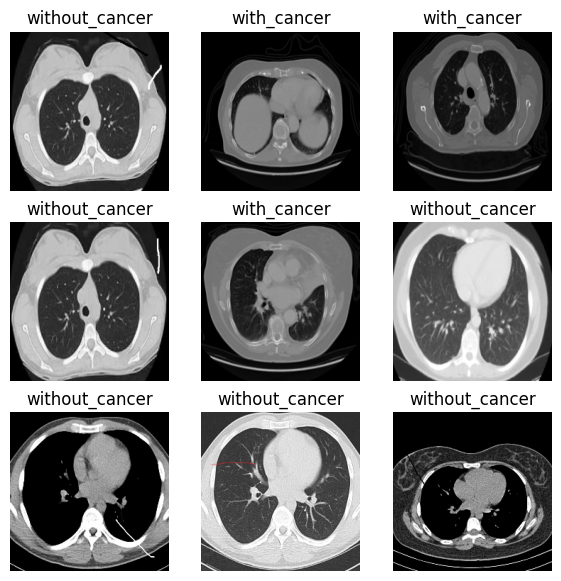

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):  # take one batch
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        label = int(labels[i].numpy())
        plt.title(class_names[label])
        plt.axis("off")


## 🧠 CNN Image Classifier

This Convolutional Neural Network (CNN) is built to classify images into **two categories** — Cancer or No-Cancer 🐶🐱.

### 🧩 Model Architecture:
- **Conv Layers (x3)**: Extract features like edges, shapes, and textures.
- **MaxPooling**: Downsamples to keep important info.
- **Flatten + Dense Layer**: Learns patterns from the extracted features.
- **Dropout (0.5)**: Prevents overfitting.
- **Sigmoid Output**: Outputs a probability for binary classification.

### ⚙️ Compiled with:
- **Loss**: `binary_crossentropy`
- **Optimizer**: `adam`
- **Metric**: `accuracy`

Let’s build it below! 👇

In [13]:
from tensorflow.keras import layers, models

# CNN model
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # for binary classification
])

# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


## 🚀 Training the Model

Time to teach our CNN! We'll feed it batches of images and labels from the training set, check its performance on the validation set, and repeat for a few epochs.

Let’s see how well it learns over 10 rounds (epochs)! 🏋️‍♂️📈


In [15]:

# Train model
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=10  # adjust as needed
)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.6408 - loss: 1.2925 - val_accuracy: 0.9483 - val_loss: 0.1957
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9856 - loss: 0.0748 - val_accuracy: 0.9655 - val_loss: 0.3525
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9894 - loss: 0.0321 - val_accuracy: 0.9483 - val_loss: 0.4073
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9979 - loss: 0.0151 - val_accuracy: 0.9655 - val_loss: 0.5254
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9894 - loss: 0.0137 - val_accuracy: 0.9483 - val_loss: 0.7343
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9979 - loss: 0.0128 - val_accuracy: 0.9655 - val_loss: 0.4718
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9979 - loss: 0.0075 - val_accuracy: 0.9655 - val_loss: 0.6196
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 0.9655 - val_loss:

## 🧪 Evaluating the Model

Now let’s see how well our trained model performs on **unseen test data**.  
We’ll measure the accuracy to find out if all that training paid off! 📊✅


In [16]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.2f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 418ms/step - accuracy: 0.9775 - loss: 0.2522
✅ Test Accuracy: 0.98


---
### 🎉 Test Results

Our model achieved an **accuracy of ~98%** and a **loss of 0.2522** on the test set — that’s excellent! 🙌

- **High accuracy** means the model is correctly classifying most images.
- **Low loss** indicates it's confident and consistent in its predictions.

Looks like our CNN has learned its stuff! 🧠🔍
